# 価値反復法と反復方策法と線形計画法の実装
+ 例1.5を基に2つの手法の実演を行う

## 設定

In [1]:
%matplotlib inline

In [2]:
from typing import List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import scipy

## 状態遷移確率と報酬の定義

In [3]:
# 状態や行動は0始まりのindexと思って、状態と行動の数だけ設定
n_state = 2
n_action = 3

# 状態遷移確率: P_t[i,j,k] = P_T(s'=i|s=j,a=k)とする
P_t = np.zeros((n_state,n_state,n_action))
P_t[0,0,0]=0.8
P_t[1,0,0]=0.2
P_t[0,0,1]=0
P_t[1,0,1]=1
P_t[0,0,2]=1
P_t[1,0,2]=0
P_t[0,1,0]=0
P_t[1,1,0]=1
# P_t[:,1,1:]は定義できないが一旦全部0にしておく

# 報酬関数 G[i,j]=g(s=i, a=j)
G = np.zeros((n_state, n_action))
G[0,0]=5
G[0,1]=10
G[0,2]=2
G[1,0]=1
# G[1,1:]は定義できないが、一旦全部0にしておく

# 価値反復法の実装
+ 割引率、閾値を設定後、価値関数の初期値$v_1(s)$を決めて、$v_{n+1}(s')$を以下のように更新する
$$
v_{n+1}(s) = \max_a \{g(s,a) + \gamma \sum_{s'} P_T(s'|s,a)v_n(s')\}
$$

+ 価値関数が収束していれば、以下の方法で決定方策$\pi(s)$を決める
$$
\pi(s) = arg\max_a \{g(s,a) + \gamma \sum_{s'} P_T(s'|s,a)v_{n+1}(s')\}
$$

In [4]:
# 繰り返しが収束しない場合のループの上限
max_loop = 1000

In [5]:
def value_iter_method(
    n_state: int,
    n_action: int,
    P_t: np.ndarray,
    G: np.ndarray,
    gamma: float,
    eps: float,
    max_loop: int = 1000,
    convergence_method: str = "inf_norm"
) -> (Optional[np.ndarray], Optional[np.ndarray], List[float], List[np.ndarray]):
    """　価値反復法の実装
    収束判定は教科書では2つ考えてあるので、それぞれの手法で判定を行えるようにしている

    + 入力:
        1. n_state: 状態数
        2. n_action: 行動数
        3: P_t: 状態遷移確率, 次状態×今状態×今行動の行列が入っている想定
        4: G: 報酬関数, 状態×行動の行列が入っている想定
        5. gamma: 割引率 \in [0, 1)
        6. eps: 収束判定で用いる閾値
        7. max_loop: 収束しない場合の設定, 大きい値を設定すればよい, max_loopまで更新したときは、警告出しても良いかも
        8. convergence_method: 収束判定に使っている評価値を設定するための文字列
            - convergence_method='inf_norm'の場合: 更新前後の状態関数(ベクトル)の最大値ノルムで評価する
            - convergence_method='min_max'の場合: 更新前後の状態関数(ベクトル)の最小の差と最大の差の差分で評価する
    + 出力: 
        1. est_value_vec: 推定された最適価値関数, 評価値が収束しない場合None
        2. est_pi_s: 推定された最適方策, 評価値が収束しない場合None
        3. convergence_val_history: convergence_method毎に計算された評価値の推移, デバッグ用
        4. value_func_history: 推定された最適価値関数の推移, デバッグ用

    Remark: 状態関数の初期値(curr_value_vec)を全部0に固定しているが、色々変えられるようにした方が良い
    """
    # convergence_methodが意図したものでない場合例外を投げる
    if convergence_method not in ('inf_norm', 'min_max'):
        raise ValueError(f"convergence_method is either 'abs' or 'min_max', convergence_method = '{convergence_method}'")
        
    # 初期設定
    curr_value_vec = np.zeros(n_state)
    convergence_val_history = []
    value_vec_history = []
    
    # 推定された価値関数と方策は収束しない場合は、Noneとする
    est_value_vec = None
    est_pi_s = None
    
    for ite in range(max_loop):
        # 価値関数の更新
        # print(curr_value_vec)
        # print(P_t * curr_value_vec[:,np.newaxis,np.newaxis])
        next_value_vec = (
            G # 状態×行動
            + gamma * (
                P_t * curr_value_vec[:,np.newaxis,np.newaxis] # value_vecをブローキャストして次状態×今状態×行動の行列を作る
            ).sum(axis=0) # 次状態を集約
        ).max(axis=1)
        # print(next_value_vec)

        # 収束判定の評価値計算
        if convergence_method == "inf_norm":
            # inf normで評価
            convergence_val = np.abs(curr_value_vec - next_value_vec).max()
            pass
        elif convergence_method == "min_max":
            # 状態関数の差の最大、最小の差で評価
            dvalue_vec = next_value_vec - curr_value_vec
            convergence_val = (dvalue_vec).max() - (dvalue_vec).min()
            pass
        else:
            # 最初に例外投げているが、convergence_methodが増えても大丈夫なように想定外なら例外を投げるようにしておく
            raise ValueError(f"convergence_method is either 'abs' or 'min_max', convergence_method = '{convergence_method}'")

        # 計算結果の過程をリストに残す
        value_vec_history.append(next_value_vec)
        convergence_val_history.append(convergence_val)

        # 収束判定, 評価値が閾値以下なら方策も計算して、ループを抜ける
        if convergence_val_history[-1] < threshold:
            est_value_vec = next_value_vec
            est_pi_s = np.argmax(G + gamma * (P_t * est_value_vec[:,np.newaxis,np.newaxis]).sum(axis=0), axis=1)
            break
        else:
            curr_value_vec = next_value_vec
        pass
    return est_value_vec, est_pi_s, convergence_val_history, value_vec_history
    pass

In [6]:
# ハイパーパラメータの設定
gamma = 0.9
threshold = 0.1

est_value_func, est_pi_s, _, _ = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=1,
)
est_value_func, est_pi_s

[10.  1.]


(None, None)

In [7]:
# ハイパーパラメータの設定
gamma = 0.9
threshold = 0.1

est_value_func, est_pi_s, _, _ = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
)
est_value_func, est_pi_s

[10.  1.]
[12.38  1.9 ]
[14.2556  2.71  ]
[15.751832  3.439   ]
[16.96033904  4.0951    ]
[17.94856211  4.68559   ]
[18.76637092  5.217031  ]
[19.45085264  5.6953279 ]
[20.02977292  6.12579511]
[20.52407962  6.5132156 ]
[20.94971614  6.86189404]
[21.31893655  7.17570464]
[21.64126115  7.45813417]
[21.92417218  7.71232075]
[22.1736217   7.94108868]
[22.39440359  8.14697981]
[22.59042695  8.33228183]
[22.76491813  8.49905365]
[22.92057071  8.64914828]
[23.0596576   8.78423345]
[23.1841155   8.90581011]
[23.29560898  9.0152291 ]
[23.3955797   9.11370619]


(array([23.3955797 ,  9.11370619]), array([0, 0], dtype=int64))

In [8]:
# ハイパーパラメータの設定
gamma = 0.95
threshold = 0.1

est_value_func, est_pi_s, _, _ = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
)
est_value_func, est_pi_s

[10.  1.]
[12.79  1.95]
[15.0909  2.8525]
[17.011059  3.709875]
[18.63328109  4.52438125]
[20.02092607  5.29816219]
[21.22255463  6.03325408]
[22.27545979  6.73159137]
[23.2083518   7.39501181]
[24.04793421  8.02526122]
[24.8455375   8.62399815]
[25.60326063  9.19279825]
[26.32309759  9.73315833]
[27.00694272 10.24650042]
[27.65659558 10.7341754 ]
[28.2737658  11.19746663]
[28.86007751 11.6375933 ]
[29.41707363 12.05571363]
[29.94621995 12.45292795]
[30.44890896 12.83028155]
[30.92646351 13.18876747]
[31.38014033 13.5293291 ]
[31.81113332 13.85286265]
[32.22057665 14.16021951]
[32.60954782 14.45220854]
[32.97907043 14.72959811]
[33.33011691 14.99311821]
[33.66361106 15.24346229]
[33.98043051 15.48128918]
[34.28140898 15.70722472]
[34.56733853 15.92186349]
[34.83897161 16.12577031]
[35.09702303 16.3194818 ]
[35.34217187 16.50350771]
[35.57506328 16.67833232]
[35.79631012 16.8444157 ]
[36.00649461 17.00219492]
[36.20616988 17.15208517]
[36.39586139 17.29448091]
[36.57606832 17.42975687]


(array([38.14984398, 18.6111432 ]), array([2, 0], dtype=int64))

[10.  1.]
[12.79  1.95]
[15.0909  2.8525]
[17.011059  3.709875]
[18.63328109  4.52438125]
[20.02092607  5.29816219]
[21.22255463  6.03325408]
[22.27545979  6.73159137]
[23.2083518   7.39501181]
[24.04793421  8.02526122]
[24.8455375   8.62399815]
[25.60326063  9.19279825]
[26.32309759  9.73315833]
[27.00694272 10.24650042]
[27.65659558 10.7341754 ]
[28.2737658  11.19746663]
[28.86007751 11.6375933 ]
[29.41707363 12.05571363]
[29.94621995 12.45292795]
[30.44890896 12.83028155]
[30.92646351 13.18876747]
[31.38014033 13.5293291 ]
[31.81113332 13.85286265]
[32.22057665 14.16021951]
[32.60954782 14.45220854]
[32.97907043 14.72959811]
[33.33011691 14.99311821]
[33.66361106 15.24346229]
[33.98043051 15.48128918]
[34.28140898 15.70722472]
[34.56733853 15.92186349]
[34.83897161 16.12577031]
[35.09702303 16.3194818 ]
[35.34217187 16.50350771]
[35.57506328 16.67833232]
[35.79631012 16.8444157 ]
[36.00649461 17.00219492]
[36.20616988 17.15208517]
[36.39586139 17.29448091]
[36.57606832 17.42975687]


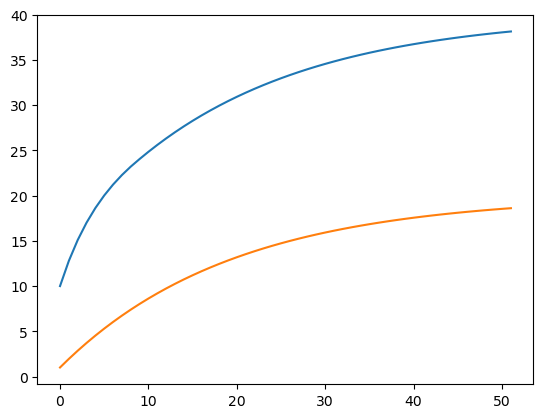

In [9]:
# ハイパーパラメータの設定
gamma = 0.95
threshold = 0.1

(_, _, _, history_value_vec) = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
    convergence_method="inf_norm",
)

print(len(history_value_vec))

plt.plot(np.array(history_value_vec)[:,0])
plt.plot(np.array(history_value_vec)[:,1])
plt.show()

[10.  1.]
[12.79  1.95]
[15.0909  2.8525]
[17.011059  3.709875]
[18.63328109  4.52438125]
[20.02092607  5.29816219]
[21.22255463  6.03325408]
[22.27545979  6.73159137]
[23.2083518   7.39501181]
[24.04793421  8.02526122]
[24.8455375   8.62399815]
[25.60326063  9.19279825]
[26.32309759  9.73315833]
[27.00694272 10.24650042]
[27.65659558 10.7341754 ]
[28.2737658  11.19746663]
[28.86007751 11.6375933 ]
[29.41707363 12.05571363]
[29.94621995 12.45292795]
[30.44890896 12.83028155]
[30.92646351 13.18876747]
[31.38014033 13.5293291 ]
[31.81113332 13.85286265]
[32.22057665 14.16021951]
[32.60954782 14.45220854]
25


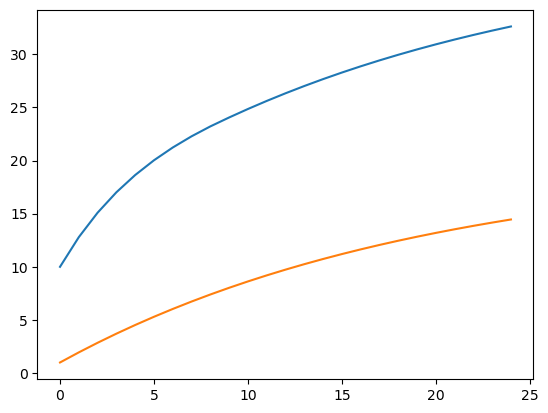

In [10]:
# ハイパーパラメータの設定
gamma = 0.95
threshold = 0.1

(_, _, _, history_value_vec) = value_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    eps=threshold,
    max_loop=max_loop,
    convergence_method="min_max",
)
print(len(history_value_vec))

plt.plot(np.array(history_value_vec)[:,0])
plt.plot(np.array(history_value_vec)[:,1])
plt.show()

# 方策反復法の実装
## アルゴリズム
+ 以下の1-4を実行する
1. 初期の決定方策$\pi^d_1$($|S|$個の要素のベクトル)を決める。
2. 決定方策$\pi^d_n$から期待ベルマン方程式から期待価値関数$V^{\pi^d_n}$($|S|$個の要素のベクトル)を計算する。$|S|$個の連立方程式を解けばよい:
$$
V^{\pi^d_n}(s)=g(s,\pi^d_n(s)) + \gamma \sum_{s'} p_T(s'|s,\pi^d_n(s))) V^{\pi^d_n}(s), for each s
$$
3. 改善方策$\pi^{d}_{n+1}(s)$を求める:
$$
\pi^{d}_{n+1}(s)=arg\max_a \{g(s,a) + \gamma \sum_{s'} p_T(s'|s,a)V^{\pi^d_n}(s')\}
$$
4. 収束判定: $\pi^d_n(s)=\pi^d_{n+1}(s), \forall s$であるならば、終了, そうでなければn=n+1として2に戻る


In [11]:
def policy_iter_method(
    n_state: int,
    n_action: int,
    P_t: np.ndarray,
    G: np.ndarray,
    gamma: float,
    max_loop: int = 1000,
    init_pi_s: Optional[np.ndarray] = None
) -> (np.ndarray, Optional[np.ndarray], List[float], List[np.ndarray]):
    """　方策反復法の実装

    + 入力:
        1. n_state: 状態数
        2. n_action: 行動数
        3: P_t: 状態遷移確率, 次状態×今状態×今行動の行列が入っている想定
        4: G: 報酬関数, 状態×行動の行列が入っている想定
        5. gamma: 割引率 \in [0, 1)
        6. max_loop: 収束しない場合の設定, 大きい値を設定すればよい, max_loopまで更新したときは、警告出しても良いかも
        7. init_pi_s: 決定方策の初期値, Noneの場合、全ての状態で0番の行動を選ぶこととする
        
    + 出力: 
        1. est_V_pi: 推定された最適価値関数
        2. est_pi_s: 推定された最適方策, 評価値が収束しない場合None
        3. pi_s_history: 各ステップで得られた推定された最適方策の推移, デバッグ用
        4. value_func_history: 各ステップで得られた推定された最適価値関数の推移, デバッグ用
    """
    # 各結果の推移を記録する変数の設定
    V_pi_history = []
    pi_s_history = []
    est_pi_s = None
    
    # 決定方策の初期化
    curr_pi_s = init_pi_s if init_pi_s is not None else np.zeros(n_state, dtype=int)
    for _ in range(max_loop):
        # 期待価値関数の計算
        #  - gamma*P_t[np.arange(n_state), :, curr_pi_s]
        est_V_pi = np.linalg.solve(
            np.eye(n_state) - gamma*np.vstack([P_t[:,i,curr_pi_s[i]] for i in range(n_state)]), # 今状態×次状態の行列にしたいので、次状態を列方向に並べる
            np.array([G[i, curr_pi_s[i]] for i in range(n_state)]),
        )
        # print(est_V_pi)
        
        # 改善方策の計算
        next_pi_s = np.argmax(
            G # g(s,a)部分
            + gamma * (P_t * est_V_pi[:,np.newaxis, np.newaxis]).sum(axis=0), # sum_{s'}...の部分
            axis=1,
        ).astype(int)
    
        # 計算過程の記録
        V_pi_history.append(est_V_pi)
        pi_s_history.append(next_pi_s)
    
        # 収束判定
        if (next_pi_s == curr_pi_s).all():
            est_pi_s = next_pi_s
            break
        else:
            curr_pi_s = next_pi_s

    return(est_V_pi, est_pi_s, pi_s_history, V_pi_history)

In [12]:
gamma = 0.9
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[24.28571429 10.        ]


(array([24.28571429, 10.        ]),
 array([0, 0]),
 [array([0, 0])],
 [array([24.28571429, 10.        ])])

In [13]:
gamma = 0.9
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[24.28571429 10.        ]


(array([24.28571429, 10.        ]),
 array([0, 0]),
 [array([0, 0])],
 [array([24.28571429, 10.        ])])

In [14]:
gamma = 0.5
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[8.66666667 2.        ]
[11.  2.]


(array([11.,  2.]),
 array([1, 0]),
 [array([1, 0]), array([1, 0])],
 [array([8.66666667, 2.        ]), array([11.,  2.])])

In [15]:
gamma = 0.95
max_loop = 1000

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[36.66666667 20.        ]
[40. 20.]


(array([40., 20.]),
 array([2, 0]),
 [array([2, 0]), array([2, 0])],
 [array([36.66666667, 20.        ]), array([40., 20.])])

# 線形計画法による解法
+ 線形計画法によって状態関数を求めると、以下のようになる:
$$
minimize_v \sum_s w(s) v(s),
$$
$$
subject \ to \ v(s) \geq g(s,a) + \gamma \sum_{s'} P_T(s'|s,a) v(s')
$$

+ ここでは、scipyの線形計画法を用いているので、
$$
minimize_v \sum_s w_s v_s,
$$
$$
subject \ to A v_s \leq -G,
$$
$$
where \ A=-T + \gamma P_t, T \in \{0,1\}^{|S||A| \times |S|}, P_t \in [0,1]^{|S||A| \times |S|}, G \in \mathbb{R}^{|S||A| \times |S|}
$$
のような形式で、今状態と今行動に対応するindexをflattenにして、行列として扱って線形計画法の関数に必要な変数を代入する

In [16]:
def linear_programming_method(
    n_state: int,
    n_action: int,
    P_t: np.ndarray,
    G: np.ndarray,
    gamma: float,
    cost_weight: Optional[np.ndarray] = None,
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], scipy.optimize.OptimizeResult]:
    """ 線形計画法を用いた価値関数の推定
    + 入力:
        1. n_state: 状態数
        2. n_action: 行動数
        3: P_t: 状態遷移確率, 次状態×今状態×今行動の行列が入っている想定
        4: G: 報酬関数, 状態×行動の行列が入っている想定
        5. gamma: 割引率 \in [0, 1)
        6. cost_weight: 各価値関数に対する重み, Noneの場合, 状態の一様分布を選ぶこととする
        
    + 出力: 
        1. est_V_pi: 推定された最適価値関数, 計算が失敗した場合はNone
        2. est_pi_s: 推定された最適方策, 計算が失敗した場合はNone
        3. opt_res: 線形計画法の結果が入ったインスタンス, デバッグ用

    """
    # 不等式制約部分の行列を作る, 行列で扱わないと線形計画法の関数に入れられないので、無理やり行列を作る
    A_ub = (
        # -Tに該当する部分の行列を作る
        -np.array([np.eye(n_state) for _ in range(n_action)]).transpose((1,2,0)).reshape((n_state, n_state*n_action)) \
        # gamma部分の行列を作る
        + gamma*P_t.reshape((n_state, n_state*n_action))
    ).T

    # 不等式制約の係数側を作る
    b_ub = -G.flatten()

    # 目的関数の重みを計算する
    _weight = np.ones(n_state) / n_state if cost_weight is None else cost_weight

    # 線形計画法の実行
    opt_res = scipy.optimize.linprog(c=_weight, A_ub=A_ub, b_ub=b_ub)

    # 線形計画法の結果に基づいて最適方策を作る
    if opt_res.success:
        est_V_pi = opt_res.x
        est_pi_s = np.argmax(
            G # g(s,a)部分
            + gamma * (P_t * est_V_pi[:,np.newaxis, np.newaxis]).sum(axis=0), # sum_{s'}...の部分
            axis=1,
        ).astype(int)
        pass
    else:
        est_V_pi = None
        est_pi_s = None
        pass
    return (est_V_pi, est_pi_s, opt_res)

In [17]:
gamma = 0.9
linear_programming_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

(array([24.28571429, 10.        ]),
 array([0, 0]),
         message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
         success: True
          status: 0
             fun: 17.14285714285715
               x: [ 2.429e+01  1.000e+01]
             nit: 0
           lower:  residual: [ 2.429e+01  1.000e+01]
                  marginals: [ 0.000e+00  0.000e+00]
           upper:  residual: [       inf        inf]
                  marginals: [ 0.000e+00  0.000e+00]
           eqlin:  residual: []
                  marginals: []
         ineqlin:  residual: [ 0.000e+00  5.286e+00  4.286e-01  0.000e+00
                               1.000e+01  1.000e+01]
                  marginals: [-1.786e+00 -0.000e+00 -0.000e+00 -8.214e+00
                              -0.000e+00 -0.000e+00]
  mip_node_count: 0
  mip_dual_bound: 0.0
         mip_gap: 0.0)

In [18]:
gamma = 0.95
linear_programming_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

(array([40., 20.]),
 array([2, 0]),
         message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
         success: True
          status: 0
             fun: 29.99999999999997
               x: [ 4.000e+01  2.000e+01]
             nit: 0
           lower:  residual: [ 4.000e+01  2.000e+01]
                  marginals: [ 0.000e+00  0.000e+00]
           upper:  residual: [       inf        inf]
                  marginals: [ 0.000e+00  0.000e+00]
           eqlin:  residual: []
                  marginals: []
         ineqlin:  residual: [ 8.000e-01  1.100e+01  0.000e+00  0.000e+00
                               2.000e+01  2.000e+01]
                  marginals: [-0.000e+00 -0.000e+00 -1.000e+01 -1.000e+01
                              -0.000e+00 -0.000e+00]
  mip_node_count: 0
  mip_dual_bound: 0.0
         mip_gap: 0.0)

# 双対問題を解く
+ 双対問題は、以下の$x(s,a)$の最小化をすればよい:
$$
maximize \sum_a \sum_s x(s,a) G(s,a)
$$
$$
subject \ to \ \sum_a' x(s,a') - \gamma \sum_{s,a} P_T(s'|s,a) x(s,a) = w(s') \ \forall s'
$$
$$
x(s,a) \geq 0 \ \forall (s,a)
$$

In [19]:
def linear_programming_method_dual(
    n_state: int,
    n_action: int,
    P_t: np.ndarray,
    G: np.ndarray,
    gamma: float,
    cost_weight: Optional[np.ndarray] = None,
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], scipy.optimize.OptimizeResult]:
    """ 双対問題を解いて、最適方策を求める関数
    """
    _weight = np.ones(n_state) / n_state if cost_weight is None else cost_weight

    # 等式制約の変数にかかる行列を求める
    A_eq = (
        # 単位行列の各要素を保ちつつ、横に伸ばしたような行列を作って、flattenした xのaについての和を行う
        scipy.linalg.block_diag(*[np.ones(n_action) for _ in range(n_state)]) 
        - gamma*P_t.flatten().reshape(n_state, n_state*n_action) # 遷移行列の今状態と今行動を足し合わせる
    )

    # 等式制約の定数側を求める
    b_eq = _weight

    # コスト関数の重みを設定
    _c = -G.flatten()
    
    # 線形計画法の実行
    opt_res = scipy.optimize.linprog(
        c=_c,
        A_ub=None, b_ub=None,
        A_eq=A_eq, b_eq=b_eq,
        bounds=(0, None),
    )

    # 線形計画法の結果に基づいて最適方策を作る
    if opt_res.success:
        # 双対問題の最適解から最適方策を求める, 双対問題で得られる確率方策の状態毎のargmaxが最適方策なので、それを行う
        est_pi_s = np.argmax(
            opt_res.x.reshape((n_state, n_action)) / (opt_res.x.reshape((n_state, n_action)).sum(axis=1)[:,np.newaxis]),
            axis=1,
        ).astype(int)

        # 状態関数は、方策反復法と同じ式で得られるので、それを流用する
        est_V_pi = np.linalg.solve(
            np.eye(n_state) - gamma*np.vstack([P_t[:,i,est_pi_s[i]] for i in range(n_state)]), # 今状態×次状態の行列にしたいので、次状態を列方向に並べる
            np.array([G[i, est_pi_s[i]] for i in range(n_state)]),
        )
        pass
    else:
        est_V_pi = None
        est_pi_s = None
        pass
    return (est_V_pi, est_pi_s, opt_res)

In [20]:
gamma = 0.9
linear_programming_method_dual(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

(array([24.28571429, 10.        ]),
 array([0, 0]),
         message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
         success: True
          status: 0
             fun: -17.14285714285715
               x: [ 1.786e+00  0.000e+00  0.000e+00  8.214e+00  0.000e+00
                    0.000e+00]
             nit: 0
           lower:  residual: [ 1.786e+00  0.000e+00  0.000e+00  8.214e+00
                               0.000e+00  0.000e+00]
                  marginals: [ 0.000e+00  5.286e+00  4.286e-01  0.000e+00
                               1.000e+01  1.000e+01]
           upper:  residual: [       inf        inf        inf        inf
                                     inf        inf]
                  marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                               0.000e+00  0.000e+00]
           eqlin:  residual: [ 0.000e+00  0.000e+00]
                  marginals: [-2.429e+01 -1.000e+01]
         ineqlin:  residual: []
               

In [21]:
gamma = 0.95
linear_programming_method_dual(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

(array([40., 20.]),
 array([2, 0]),
         message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
         success: True
          status: 0
             fun: -29.99999999999997
               x: [ 0.000e+00  0.000e+00  1.000e+01  1.000e+01  0.000e+00
                    0.000e+00]
             nit: 0
           lower:  residual: [ 0.000e+00  0.000e+00  1.000e+01  1.000e+01
                               0.000e+00  0.000e+00]
                  marginals: [ 8.000e-01  1.100e+01  0.000e+00  0.000e+00
                               2.000e+01  2.000e+01]
           upper:  residual: [       inf        inf        inf        inf
                                     inf        inf]
                  marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                               0.000e+00  0.000e+00]
           eqlin:  residual: [ 0.000e+00  0.000e+00]
                  marginals: [-4.000e+01 -2.000e+01]
         ineqlin:  residual: []
                  marginals: []

# 状態数を増やしたときの比較

In [68]:
n_state = 50
n_action = 30

In [69]:
data_seed = 20240709
np.random.seed(data_seed)

In [70]:
G = np.random.randint(low=0, high=10, size=(n_state, n_action))
P_t = np.random.dirichlet(alpha=np.ones(n_state), size=(n_state, n_action)).transpose((2, 0, 1))

In [71]:
%%timeit
gamma = 0.95
linear_programming_method_dual(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

152 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
%%timeit
gamma = 0.95
linear_programming_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

77.4 ms ± 4.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
gamma = 0.95
max_loop = 100

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[84.85840599 79.33181502 78.01441419 80.28612534 82.42111517 81.56627073
 84.51819561 78.00519817 80.44469302 85.67253874 78.66204834 80.70964803
 82.32504246 81.86591286 81.88526551 86.34251287 78.0473756  79.94612757
 81.04415515 78.26349726 86.71196531 86.91904995 80.93013163 78.31161299
 84.64208956 77.51527035 77.19903021 83.48130058 85.49190319 82.61908013
 78.52695719 83.08339673 85.51640065 85.96068928 82.04689709 81.7858092
 84.1647316  81.15600593 83.81515762 79.81993082 85.17916274 83.25717245
 79.87046366 80.57686201 78.42127417 80.36337396 83.06126034 80.16390371
 84.94393316 85.67342443]
[177.37261387 177.5107553  177.48422513 177.44025541 177.51154451
 177.48869974 177.45435322 177.45866293 177.47679114 177.55372903
 177.46043476 177.54917427 177.45553057 177.5299201  177.54108958
 177.55455819 177.3995558  177.50499963 177.48064108 177.49544874
 177.47532385 177.52117879 177.55404989 177.51362751 177.42837365
 177.47331051 177.37619372 177.54743993 177.52845378 177.4910

In [74]:
n_state = 30
n_action = 50

In [75]:
data_seed = 20240709
np.random.seed(data_seed)

In [76]:
G = np.random.randint(low=0, high=10, size=(n_state, n_action))
P_t = np.random.dirichlet(alpha=np.ones(n_state), size=(n_state, n_action)).transpose((2, 0, 1))

In [77]:
%%timeit
gamma = 0.95
linear_programming_method_dual(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

56.9 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
%%timeit
gamma = 0.95
linear_programming_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
)

38.6 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%%timeit
gamma = 0.95
max_loop = 100

policy_iter_method(
    n_state=n_state,
    n_action=n_action,
    P_t=P_t,
    G=G,
    gamma=gamma,
    max_loop=max_loop,
)

[103.09682075 103.75156567 100.27611501  99.31376818 104.19148672
 105.20070005  96.8234085  101.44326244 102.32180237 104.29988702
  99.02540017 101.96632518 103.0687119  104.65865325  96.48882282
  95.87518435  99.43644092  96.7853704   96.55627097  97.9758318
 103.21580324 100.30453031  95.82379595 103.06825228 103.45527239
 102.00457868 103.05358284  97.41628204 103.22005691 103.68785384]
[178.71608119 178.68331603 178.72172152 178.71580575 178.66426218
 178.62310308 178.7086359  178.68907685 178.67376601 178.70109633
 178.68152193 178.71384785 178.71075792 178.70074182 178.61608018
 178.65036684 178.66846537 178.67919659 177.62627224 178.69996881
 178.55315055 177.65729875 178.70088827 178.6480625  178.61760353
 178.71349723 177.71636548 178.71623457 178.68804833 178.67899265]
[179.17916325 179.16535763 179.18123331 179.17298987 179.16074183
 179.1678301  179.17059318 179.14968653 179.14464779 179.17677252
 179.18772289 179.16597921 179.18909198 179.1620511  179.12661883
 179.1208

# 試行錯誤の跡

In [ ]:
# x = np.random.normal(size=(n_state*n_action))

# (
#     scipy.linalg.block_diag(*[np.ones(n_action) for _ in range(n_state)]) # 単位行列の各要素を保ちつつ、横に伸ばしたような行列を作って、flattenした xのaについての和を行う
#     - gamma*P_t.flatten().reshape(n_state, n_state*n_action) # 遷移行列の今状態と今行動を足し合わせる
# ) @ x

# P_t.reshape((n_state, n_state*n_action))

# P_t.flatten().reshape(n_state, n_state*n_action) @ x

# P_t[1]

# np.[P_t[i].flatten() for i in range(n_state)]

# P_t

# np.eye(2,6)

# np.array([np.eye(n_state) for _ in range(n_action)]).transpose((1,2,0))

# np.eye(n_state)

# x

# n_action, n_state

# G



# A_eq = (
#     scipy.linalg.block_diag(*[np.ones(n_action) for _ in range(n_state)]) # 単位行列の各要素を保ちつつ、横に伸ばしたような行列を作って、flattenした xのaについての和を行う
#     - gamma*P_t.flatten().reshape(n_state, n_state*n_action) # 遷移行列の今状態と今行動を足し合わせる
# )

# weight = np.ones(n_state) / n_state

# b_eq = weight

# res = scipy.optimize.linprog(
#     c=-G.flatten(),
#     A_ub=None, b_ub=None, # 不等式制約はxの値域だけなので、そっちで定義
#     A_eq=A_eq, b_eq=b_eq,
#     bounds=(0, None)
# )

# np.argmax(
#     res.x.reshape((n_state, n_action)) / (res.x.reshape((n_state, n_action)).sum(axis=1)[:,np.newaxis]),
#     axis=1,
# )

# G.flatten() @ res.x

# A_ub = (
#     -np.array([np.eye(n_state) for _ in range(n_action)]).transpose((1,2,0)).reshape((n_state, n_state*n_action)) \
#     + gamma*P_t.reshape((n_state, n_state*n_action))
# ).T

# b_ub = -G.flatten()

# weight = np.ones(n_state) / n_state

# res = scipy.optimize.linprog(c=weight, A_ub=A_ub, b_ub=b_ub)

# est_value_func = res.x

# est_pi_s = np.argmax(
#     G # g(s,a)部分
#     + gamma * (P_t * est_value_func[:,np.newaxis, np.newaxis]).sum(axis=0), # sum_{s'}...の部分
#     axis=1,
# ).astype(int)


# est_pi_s

# est_value_func

# res.x



# (
#     np.array([np.eye(n_state) for _ in range(n_action)]).transpose((1,2,0)).reshape((n_state, n_state*n_action)) \
#     - gamma*P_t.reshape((n_state, n_state*n_action))
# ).T @ est_value_func

# est_value_func[:,np.newaxis] - G - gamma * (P_t * est_value_func[:,np.newaxis, np.newaxis]).sum(axis=0)



# P_t[1].flatten()

# P_t[1]

# P_t.reshape((n_state, n_state*n_action))

# G

# G.flatten()

# - gamma * (P_t * est_value_func[:,np.newaxis, np.newaxis]).sum(axis=0)

# est_value_func[:,np.newaxis] - G - gamma * (P_t * est_value_func[:,np.newaxis, np.newaxis]).sum(axis=0)



In [ ]:
# # 各結果の推移を記録する変数の設定
# V_pi_history = []
# pi_s_history = []

# # 決定方策の初期化
# curr_pi_s = np.zeros(n_state, dtype=int) + 2

# for _ in range(max_loop):
#     # 期待価値関数の計算
#     #  - gamma*P_t[np.arange(n_state), :, curr_pi_s]
#     est_V_pi = np.linalg.solve(
#         np.eye(n_state) - gamma*np.vstack([P_t[:,i,curr_pi_s[i]] for i in range(n_state)]), # 今状態×次状態の行列にしたいので、次状態を列方向に並べている
#         np.array([G[i, curr_pi_s[i]] for i in range(n_state)]),
#     )
    
#     # 改善方策の計算
#     next_pi_s = np.argmax(
#         G # g(s,a)部分
#         + gamma * (P_t * est_V_pi[:,np.newaxis, np.newaxis]).sum(axis=0), # sum_{s'}...の部分
#         axis=1,
#     ).astype(int)

#     # 計算過程の記録
#     V_pi_history.append(est_V_pi)
#     pi_s_history.append(next_pi_s)

#     # 収束判定
#     if (next_pi_s == curr_pi_s).all():
#         break
#     else:
#         curr_pi_s = next_pi_s

# V_pi_history

# pi_s_history



# G.shape

# curr_pi_s

# P_t.shape

# # 初期設定
# curr_value_vec = np.zeros(n_state)
# inf_norm_history = []
# value_vec_history = []

# # 推定された価値関数と方策は収束しない場合は、Noneとする
# est_value_vec = None
# est_pi_s = None

# for ite in range(max_loop):
#     # 価値関数の更新
#     next_value_vec = (
#         G # 状態×行動
#         + gamma * (
#             P_t * curr_value_vec[:,np.newaxis,np.newaxis] # value_vecをブローキャストして次状態×今状態×行動の行列を作る
#         ).sum(axis=0) # 次状態を集約
#     ).max(axis=1)
#     # 現在の状態と前の状態のinf normを格納しておく
#     inf_norm_history.append(np.abs(curr_value_vec - next_value_vec).max())
#     value_vec_history.append(next_value_vec)

#     # 収束判定
#     if inf_norm_history[-1] < threshold:
#         est_value_vec = next_value_vec
#         est_pi_s = np.argmax(G + gamma * (P_t * est_value_vec[:,np.newaxis,np.newaxis]).sum(axis=0), axis=1)
#         break
#     else:
#         curr_value_vec = next_value_vec

# value_vec_history

# est_pi_s

# est_value_vec

# plt.plot(inf_norm_history)

# np.abs(curr_value_vec - next_value_vec).max()

# # [
# #     G[s,:] + gamma * (P_t[:,s,:] * value_vec[:,np.newaxis]).sum(axis=0)
# #     for s in range(n_state)
# # ]

